# Wind Farm Spotter: Training Inception v3

### **Environment Setup**

In [0]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
!pip install pytorchcv

     |████████████████████████████████| 368kB 3.5MB/s 


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import fastai
from fastai.vision import *
from pytorchcv.model_provider import get_model as ptcv_get_model
import warnings
warnings.filterwarnings('ignore')

In [5]:
print(fastai.__version__)

1.0.59


### **Data Preprocessing**

In [6]:
path = Path("/content/drive/My Drive/dla-project/data/")
path.ls()

[PosixPath('/content/drive/My Drive/dla-project/data/test'),
 PosixPath('/content/drive/My Drive/dla-project/data/train'),
 PosixPath('/content/drive/My Drive/dla-project/data/test_single'),
 PosixPath('/content/drive/My Drive/dla-project/data/effnet-b1-c9-sd'),
 PosixPath('/content/drive/My Drive/dla-project/data/effnet-b1-sd.pth'),
 PosixPath('/content/drive/My Drive/dla-project/data/incept-v3-80-sd.pth')]

In [0]:
bs = 32 
size = 299
tfms = ([crop_pad()], [])

In [8]:
src = ImageList.from_folder(path/'train').split_by_rand_pct().label_from_folder().transform(tfms, size=size)   
src

LabelLists;

Train: LabelList (884 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
turbines_low_capacity,turbines_low_capacity,turbines_low_capacity,turbines_low_capacity,turbines_low_capacity
Path: /content/drive/My Drive/dla-project/data/train;

Valid: LabelList (220 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
no_turbines_high_potential,turbines_low_capacity,turbines_medium_capacity,turbines_high_capacity,turbines_high_capacity
Path: /content/drive/My Drive/dla-project/data/train;

Test: None

In [0]:
#Creating Databunch (Loaders) and Normalizing
data = (src).databunch(bs=bs).normalize(imagenet_stats)

In [10]:
#Labels
data.classes

['no_turbines_high_potential',
 'no_turbines_low_potential',
 'no_turbines_med_potential',
 'no_turbines_no_potential',
 'turbines_high_capacity',
 'turbines_low_capacity',
 'turbines_medium_capacity']

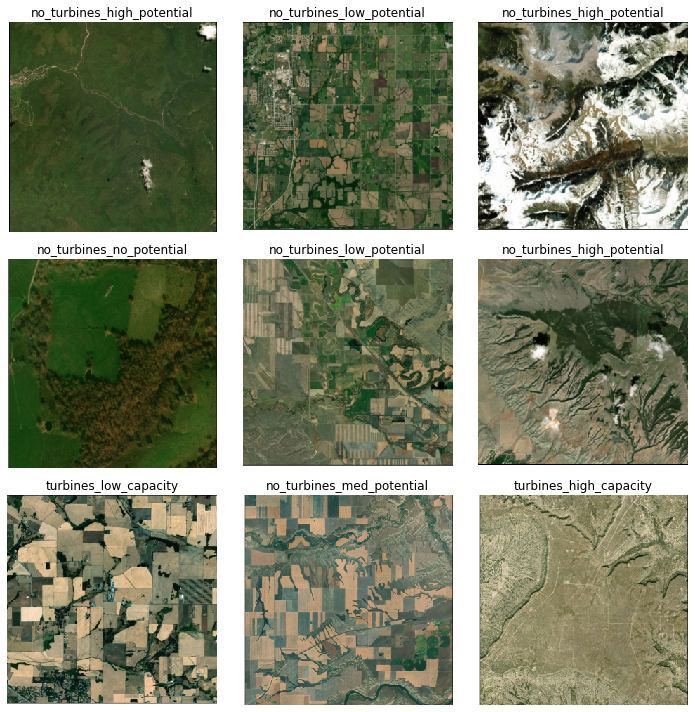

In [11]:
#Example Batch
data.show_batch(rows=3, figsize=(10, 10))

### **Architecture Definition and Exploration**










In [0]:
#https://github.com/PPPW/deep-learning-random-explore/blob/master/CNN_archs/utils.py
def arch_summary(arch):
    model = arch(False)
    tot = 0
    for i, l in enumerate(model.children()):
        n_layers = len(flatten_model(l))
        tot += n_layers
        print(f'({i}) {l.__class__.__name__:<12}: {n_layers:<4}layers (total: {tot})')


def get_groups(model, layer_groups):
    group_indices = [len(g) for g in layer_groups]
    curr_i = 0
    group = []
    for layer in model:
        group_indices[curr_i] -= len(flatten_model(layer))
        group.append(layer.__class__.__name__)
        if group_indices[curr_i] == 0:
            curr_i += 1
            print(f'Group {curr_i}:', group)   
            group = []

In [13]:
arch = ptcv_get_model("inceptionv3", pretrained=True)
arch_summary(lambda _: arch.features)

(0) InceptInitBlock: 17  layers (total: 17)
(1) Sequential  : 66  layers (total: 83)
(2) Sequential  : 137 layers (total: 220)
(3) Sequential  : 75  layers (total: 295)
(4) AvgPool2d   : 1   layers (total: 296)


In [14]:
for i in range(4):
    print(f'---------({i})---------')
    arch_summary(lambda _: arch.features[i])

---------(0)---------
(0) InceptConv  : 3   layers (total: 3)
(1) InceptConv  : 3   layers (total: 6)
(2) InceptConv  : 3   layers (total: 9)
(3) MaxPool2d   : 1   layers (total: 10)
(4) InceptConv  : 3   layers (total: 13)
(5) InceptConv  : 3   layers (total: 16)
(6) MaxPool2d   : 1   layers (total: 17)
---------(1)---------
(0) InceptionAUnit: 22  layers (total: 22)
(1) InceptionAUnit: 22  layers (total: 44)
(2) InceptionAUnit: 22  layers (total: 66)
---------(2)---------
(0) ReductionAUnit: 13  layers (total: 13)
(1) InceptionBUnit: 31  layers (total: 44)
(2) InceptionBUnit: 31  layers (total: 75)
(3) InceptionBUnit: 31  layers (total: 106)
(4) InceptionBUnit: 31  layers (total: 137)
---------(3)---------
(0) ReductionBUnit: 19  layers (total: 19)
(1) InceptionCUnit: 28  layers (total: 47)
(2) InceptionCUnit: 28  layers (total: 75)


In [0]:
def inceptionv3(pretrained=True):
    return ptcv_get_model("inceptionv3", pretrained=pretrained).features

### **Discriminative Model Layer Training and Transfer Learning**

In [21]:
#Fastai Learner (Model with built-in Training Tools)
learn = cnn_learner(data, inceptionv3, pretrained=True, metrics=[error_rate, accuracy], cut=noop, split_on=lambda m: (m[0][3], m[1]))
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [32, 149, 149]       864        False     
______________________________________________________________________
BatchNorm2d          [32, 149, 149]       64         True      
______________________________________________________________________
ReLU                 [32, 149, 149]       0          False     
______________________________________________________________________
Conv2d               [32, 147, 147]       9,216      False     
______________________________________________________________________
BatchNorm2d          [32, 147, 147]       64         True      
______________________________________________________________________
ReLU                 [32, 147, 147]       0          False     
______________________________________________________________________
Conv2d               [64, 147, 147]       18,432     False     
___________________________________________________

In [22]:
get_groups(nn.Sequential(*learn.model[0], *learn.model[1]), learn.layer_groups)

Group 1: ['InceptInitBlock', 'Sequential', 'Sequential']
Group 2: ['Sequential', 'AvgPool2d']
Group 3: ['AdaptiveConcatPool2d', 'Flatten', 'BatchNorm1d', 'Dropout', 'Linear', 'ReLU', 'BatchNorm1d', 'Dropout', 'Linear']


In [19]:
gc.collect()

23


### **Training: Stage 1**

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


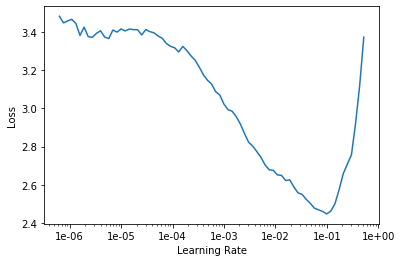

In [0]:
learn.lr_find(wd=2e-2)
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


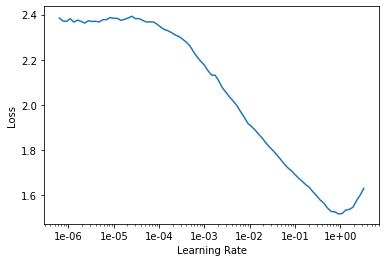

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
gc.collect()

0

In [23]:
learn.fit_one_cycle(2, 4e-2)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,2.698954,2.201731,0.572727,0.427273,06:35
1,2.252252,1.550142,0.459091,0.540909,04:23


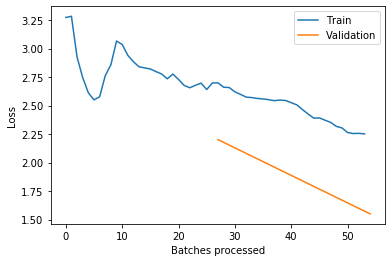

In [24]:
#Losses for First Fitting
learn.recorder.plot_losses()

In [25]:
gc.collect()

2977

In [0]:
#Save .pth File  
import torch
learn.save('wfs-incept-phase1-a')
torch.save(learn.model.state_dict(), path/'wfs-incept-sd1.pth')

### **Training: Stage 2**

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


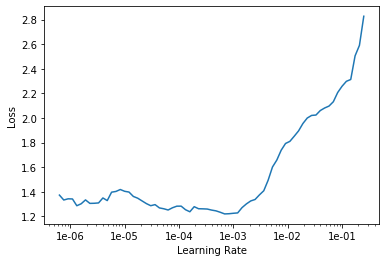

In [27]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


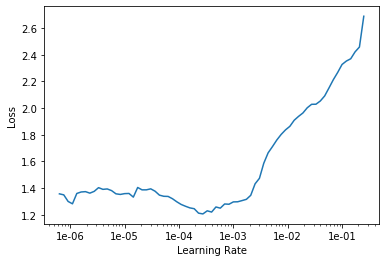

In [28]:
learn.lr_find(wd=2e-2)
learn.recorder.plot()

In [29]:
gc.collect()

6936

In [30]:
learn.fit_one_cycle(2, (4e-4,4e-4,4e-4), wd=2e-2)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.500807,2.006798,0.436364,0.563636,04:22
1,1.275751,0.990438,0.372727,0.627273,04:23


In [31]:
gc.collect()

14

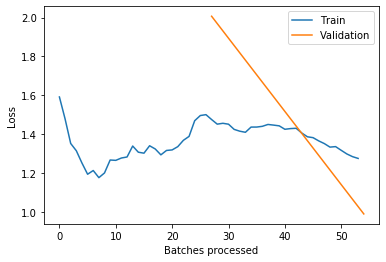

In [32]:
#Losses for First Fitting
learn.recorder.plot_losses()

In [0]:
#Save .pth File  
learn.save('wfs-incept-phase2-b')
torch.save(learn.model.state_dict(), path/'wfs-incept-sd2.pth')

### **Training: Stage 3**

In [34]:
gc.collect()

2762

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


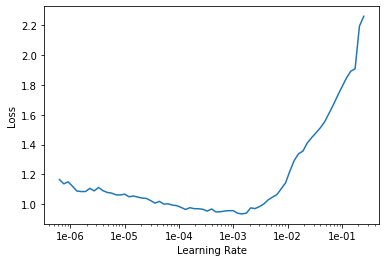

In [35]:
#Generate New Augmented Images
size=315
src = ImageList.from_folder(path/'train').split_by_rand_pct().label_from_folder().transform(tfms, size=size)   
data2 = (src).databunch(bs=bs).normalize(imagenet_stats)
#Attach to the Learner 
learn.data = data2 
learn.lr_find(wd=2e-2)
learn.recorder.plot()

In [36]:
gc.collect()

6888

In [37]:
learn.fit_one_cycle(2, (4e-5,4e-4,4e-4))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.017831,0.633632,0.204545,0.795455,04:35
1,0.745882,0.610958,0.204545,0.795455,04:33


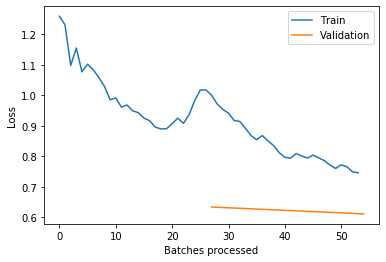

In [38]:
#Losses for First Fitting
learn.recorder.plot_losses()

In [39]:
gc.collect()

2806

In [0]:
#Save .pth File  
learn.save('wfs-incept-phase3-c')
torch.save(learn.model.state_dict(), path/'wfs-incept-sd3.pth')

### **Training: Stage 4**

In [41]:
gc.collect()

0

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


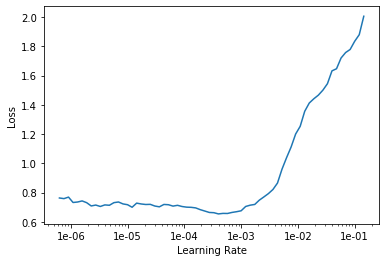

In [42]:
#Generate New Augmented Images
size=331
src = ImageList.from_folder(path/'train').split_by_rand_pct().label_from_folder().transform(tfms, size=size)   
data3 = (src).databunch(bs=bs).normalize(imagenet_stats)
#Attach to the Learner 
learn.data = data3 
learn.lr_find(wd=2e-2)
learn.recorder.plot()

In [43]:
gc.collect()

6920

In [44]:
learn.fit_one_cycle(2, (4e-4,4e-4,4e-4), wd=2e-2)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.852063,1.805385,0.368182,0.631818,04:38
1,0.911421,0.823681,0.268182,0.731818,04:26


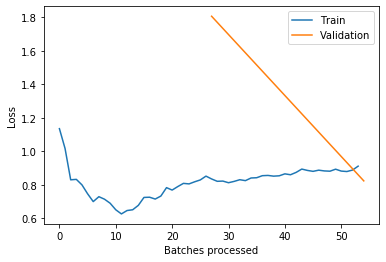

In [45]:
#Losses for First Fitting
learn.recorder.plot_losses()

In [46]:
gc.collect()

2806

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


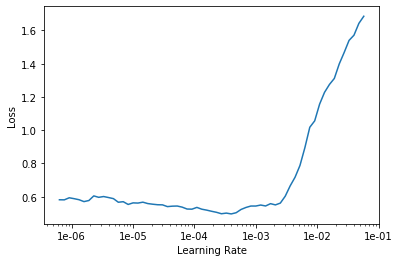

In [47]:
learn.lr_find(wd=2e-2)
learn.recorder.plot()

In [48]:
learn.fit_one_cycle(2, (4e-5,4e-4,4e-4), wd=2e-2)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.602093,0.654880,0.254545,0.745455,04:35
1,0.393798,0.714301,0.236364,0.763636,04:38


In [0]:
#Save .pth File  
learn.save('wfs-incept-phase4-d')
torch.save(learn.model.state_dict(), path/'wfs-incept-sd4.pth')

### **Training: Stage 4**

In [50]:
gc.collect()

6847

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


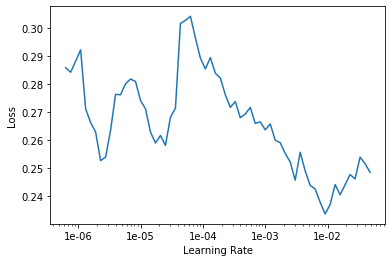

In [51]:
learn.freeze()
learn.lr_find(wd=2e-2)
learn.recorder.plot()

In [52]:
gc.collect()

6383

In [53]:
learn.fit_one_cycle(2, 4e-3, 2e-2)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.276052,0.887629,0.245455,0.754545,04:28
1,0.222291,0.950027,0.263636,0.736364,04:29


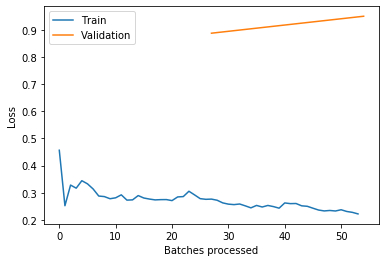

In [54]:
#Losses for First Fitting
learn.recorder.plot_losses()

In [0]:
learn.save('wfs-incept-phase5-e')
torch.save(learn.model.state_dict(), path/'wfs-incept-sd5.pth')

In [56]:
gc.collect()

2891

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


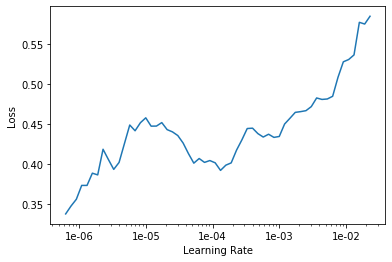

In [57]:
#Generate New Augmented Images
size=347
src = ImageList.from_folder(path/'train').split_by_rand_pct().label_from_folder().transform(tfms, size=size)   
data4 = (src).databunch(bs=bs).normalize(imagenet_stats)
#Attach to the Learner 
learn.data = data4 
learn.lr_find(wd=2e-2)
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


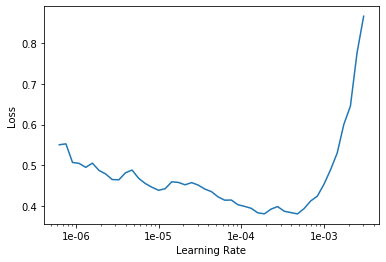

In [58]:
learn.unfreeze()
learn.lr_find(wd=2e-2)
learn.recorder.plot()

In [0]:
learn.load('wfs-incept-phase5-e')
learn.model.load_state_dict(torch.load(path/'wfs-incept-sd5.pth'))
learn.data = data4
learn.unfreeze()


In [62]:
learn.fit_one_cycle(4, (4e-4, 4e-4, 4e-4), wd=2e-2)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.527266,1.004096,0.245455,0.754545,04:39
1,0.800968,3.111678,0.368182,0.631818,04:40
2,0.852924,0.913232,0.245455,0.754545,04:42
3,0.629695,0.721976,0.236364,0.763636,04:43


In [0]:
learn.save('wfs-incept-phase6-f')
torch.save(learn.model.state_dict(), path/'wfs-incept-sd6.pth')

In [64]:
gc.collect()

152

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


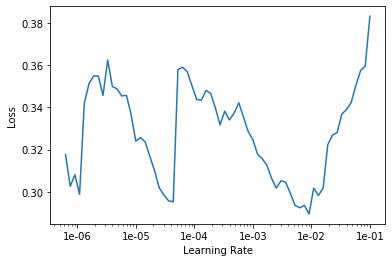

In [65]:
learn.freeze()
learn.lr_find(wd=2e-2)
learn.recorder.plot()

In [66]:
learn.fit_one_cycle(4, 4e-3, wd=2e-2)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.284530,0.652567,0.186364,0.813636,04:38
1,0.240733,0.800102,0.209091,0.790909,04:37
2,0.215131,0.801007,0.190909,0.809091,04:36
3,0.158444,0.803773,0.222727,0.777273,04:37


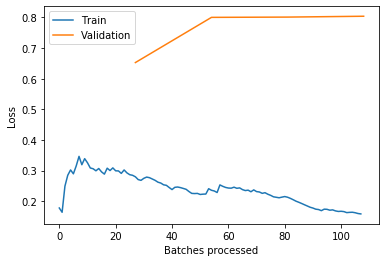

In [67]:
#Losses for First Fitting
learn.recorder.plot_losses()

In [0]:
learn.save('wfs-incept-phase7-g')
torch.save(learn.model.state_dict(), path/'wfs-incept-sd7.pth')

In [69]:
gc.collect()

9553

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


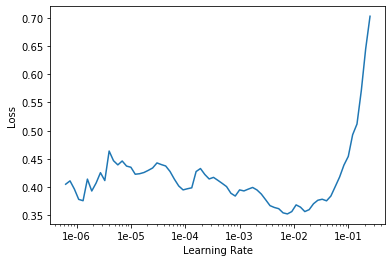

In [70]:
#Generate New Augmented Images
size=363
src = ImageList.from_folder(path/'train').split_by_rand_pct().label_from_folder().transform(tfms, size=size)   
data5 = (src).databunch(bs=bs).normalize(imagenet_stats)
#Attach to the Learner 
learn.data = data5 
learn.lr_find(wd=2e-2)
learn.recorder.plot()

In [71]:
learn.fit_one_cycle(4, (4e-3, 4e-3, 4e-3), wd=2e-2)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.421856,0.268676,0.059091,0.940909,04:45
1,0.350781,0.328137,0.081818,0.918182,04:38
2,0.267288,0.285006,0.068182,0.931818,04:36
3,0.260917,0.294447,0.054545,0.945455,04:36


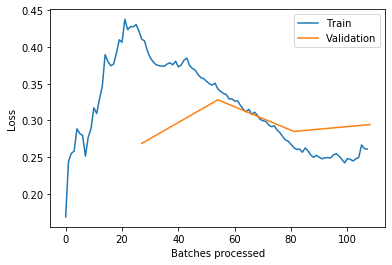

In [72]:
#Losses for First Fitting
learn.recorder.plot_losses()

In [0]:
learn.save('wfs-incept-phase8-h')
torch.save(learn.model.state_dict(), path/'wfs-incept-sd8.pth')

In [74]:
gc.collect()

9722

In [0]:
learn.export(file="incept-v3-95-2.pkl")

### **Evaluation**

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

In [77]:
interp.plot_top_losses(9, figsize=(20, 20))

Output hidden; open in https://colab.research.google.com to view.

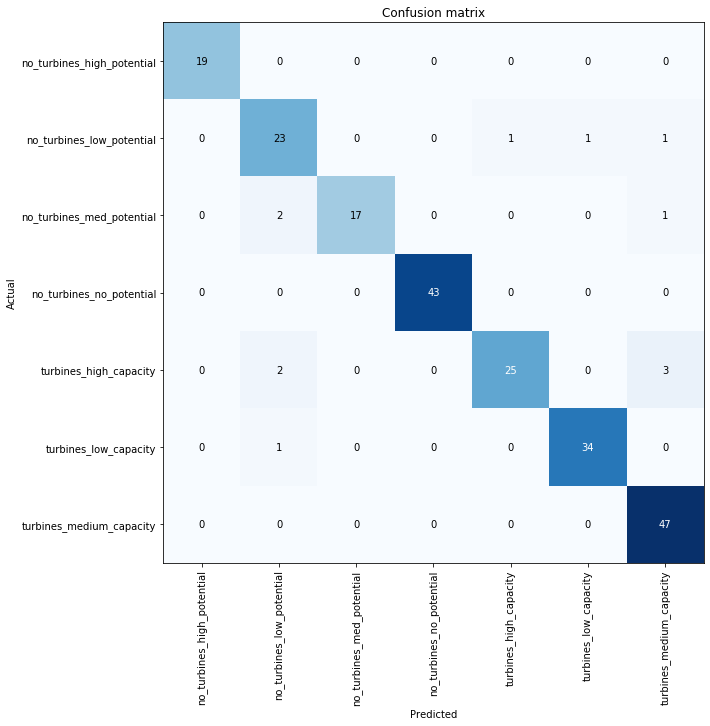

In [78]:
interp.plot_confusion_matrix(figsize=(10, 10))

### **Training Notes:**